In [1]:
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

from keras import layers, models, callbacks
from keras import optimizers, regularizers
from keras import losses, metrics
from keras.utils import plot_model
from keras.utils import serialize_keras_object, to_categorical

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

2025-07-13 10:35:42.020036: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 10:35:42.194349: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

---
# Завантажуємо датасет
---

In [3]:
# Завантаження датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 1. Нормалізація пікселів (0-255 -> 0-1)
x_train, x_test = (x_train / 255.0).astype("float32"), (x_test / 255.0).astype(
    "float32"
)

# 2. Поділ на train/val (10 % для валідації)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)


# 3. Функція для графіків
def plot_history(h, title=""):
    plt.plot(h.history["loss"], label="train loss")
    plt.plot(h.history["val_loss"], label="val loss")
    plt.plot(h.history["accuracy"], label="train acc")
    plt.plot(h.history["val_accuracy"], label="val acc")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

In [4]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(54000, 28, 28) (54000,)
(10000, 28, 28) (10000,)
(6000, 28, 28) (6000,)


In [5]:
# Список назв класів
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Виведення назви класу для першого зображення
index = 0  # Індекс зображення
print(f"Мітка: {y_train[index]}, Назва класу: {class_names[y_train[index]]}")

Мітка: 8, Назва класу: Bag


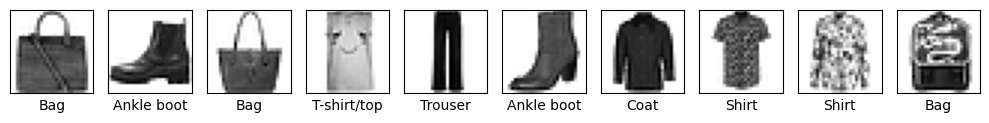

In [6]:
plt.figure(figsize=(10, 10))
# Цикл для відображення перших 10 зображень
for i in range(10):
    plt.subplot(1, 10, i + 1)

    # Видалення осей (ticks) для кращої візуалізації
    plt.xticks([])
    plt.yticks([])

    # Відображення зображення у градаціях сірого (чорно-білий режим)
    plt.imshow(x_train[i], cmap=plt.cm.binary)

    # Додавання підпису з назвою класу під зображенням
    plt.xlabel(class_names[y_train[i]])

# Показ всіх створених графіків
plt.tight_layout()  # Автоматичне регулювання відступів
plt.show()

---
# Частина 2 - VGG16
---

In [7]:
import numpy as np
import tensorflow as tf
from keras.applications import VGG16
from keras import layers, datasets, models
from keras.applications.vgg16 import preprocess_input
from skimage.color import gray2rgb
from keras.utils import array_to_img, img_to_array, to_categorical
from PIL import Image

In [ ]:
# Завантаження та підготовка даних
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()


# Змінюємо розмір зображень на 48х48 (розмір вхідного зображення для VGG16)
def resize_grayscale_images(data, target_size=(48, 48)):
    """
    Змінює розмір grayscale-зображень до target_size і нормалізує (опціонально).

    Parameters:
        data (np.ndarray): Масив зображень (N, H, W)
        target_size (tuple): Розмір зображення (ширина, висота)
        normalize (bool): Чи нормалізувати значення [0, 255] → [0, 1]

    Returns:
        np.ndarray: Масив resized зображень у форматі (N, H, W, 1)
    """
    resized = []
    for img in data:
        # Розширюємо до (H, W, 1)
        img = np.expand_dims(img, axis=-1)
        pil_img = array_to_img(img)
        resized_img = pil_img.resize(target_size, Image.BILINEAR)
        arr = img_to_array(resized_img) / 255.0
        resized.append(arr)
    return np.array(resized)


x_train_resized = resize_grayscale_images(x_train, target_size=(48, 48))
x_test_resized = resize_grayscale_images(x_test, target_size=(48, 48))

In [ ]:
# Розширення до 3 каналів (grayscale → RGB)
x_train_rgb = np.array([gray2rgb(img).squeeze() for img in x_train_resized])
x_test_rgb = np.array([gray2rgb(img).squeeze() for img in x_test_resized])

In [ ]:
x_train_rgb.shape, x_test_rgb.shape

In [ ]:
# Зробимо tf.data.Dataset
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # нормалізація
    return image, label


# ❗ Створення tf.data.Dataset
batch_size = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train_rgb, y_train))
train_ds = (
    train_ds.map(preprocess).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test_rgb, y_test))
test_ds = test_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds.element_spec, test_ds.element_spec

## Зробимо базову модель

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

In [ ]:
base_model.summary()

In [ ]:
base_model.trainable = False  # заморожуємо базу

#  Побудова власного класифікатора
model = models.Sequential(
    [
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax"),  # 10 класів Fashion MNIST
    ]
)

In [ ]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
# Тренуємо модель
model.fit(train_ds, validation_data=test_ds, epochs=10)

In [ ]:
history = model.history
epoch = history.epoch
epoch, history

In [ ]:
# Візуалізація історії тренування
plt.figure(figsize=(10, 5))
plt.plot(epoch, history.history["loss"], label="train loss")
plt.plot(epoch, history.history["val_loss"], label="val loss")
plt.plot(epoch, history.history["accuracy"], label="train acc")
plt.plot(epoch, history.history["val_accuracy"], label="val acc")
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 2. Побудова моделі з VGG16 + Fine-tuning

In [ ]:
# Розморожуємо останні 4 шари
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Перекомпіляція з меншою швидкістю навчання
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Додаткове навчання
model.fit(train_ds, validation_data=test_ds, epochs=5)

In [ ]:
history = model.history
epoch = history.epoch

# Візуалізація історії тренування
plt.figure(figsize=(10, 5))
plt.plot(epoch, history.history["loss"], label="train loss")
plt.plot(epoch, history.history["val_loss"], label="val loss")
plt.plot(epoch, history.history["accuracy"], label="train acc")
plt.plot(epoch, history.history["val_accuracy"], label="val acc")
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)

print(f"Тестова точність: {test_acc:.3%}")
print(f"Тестова втрата: {test_loss:.4f}")

In [ ]:
y_true.shape[1] == 10

In [ ]:
# Список назв класів
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Отримати передбачення
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Витягти реальні мітки з test_ds
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Друк звіту
print(
    classification_report(y_true_classes, predicted_classes, target_names=class_names)
)